In [1]:
import librosa
import numpy as np
import pandas as pd
import pickle
import os
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    ReduceLROnPlateau
)
import tensorflow as tf
from typing import Tuple
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
import seaborn as sns

warnings.filterwarnings("ignore", category=ConvergenceWarning)

## Utility Functions

In [2]:
def detect_key(chroma_vals: np.ndarray) -> Tuple[str, str]:
    """Detect the key and mode (major or minor) of the audio segment."""
    note_names = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
    major_profile = np.array([6.35, 2.23, 3.48, 2.33, 4.38, 4.09, 2.52, 5.19, 2.39, 3.66, 2.29, 2.88])
    minor_profile = np.array([6.33, 2.68, 3.52, 5.38, 2.60, 3.53, 2.54, 4.75, 3.98, 2.69, 3.34, 3.17])
    major_profile /= np.linalg.norm(major_profile)
    minor_profile /= np.linalg.norm(minor_profile)
    major_correlations = [np.corrcoef(chroma_vals, np.roll(major_profile, i))[0, 1] for i in range(12)]
    minor_correlations = [np.corrcoef(chroma_vals, np.roll(minor_profile, i))[0, 1] for i in range(12)]
    max_major_idx = np.argmax(major_correlations)
    max_minor_idx = np.argmax(minor_correlations)
    mode = 'major' if major_correlations[max_major_idx] > minor_correlations[max_minor_idx] else 'minor'
    key = note_names[max_major_idx if mode == 'major' else max_minor_idx]
    return key, mode

def calculate_ki_chroma(y: np.ndarray, sr: int, hop_length: int) -> np.ndarray:
    """Calculate a normalized, key-invariant chromagram for the given audio waveform."""
    chromagram = librosa.feature.chroma_cqt(y=y, sr=sr, hop_length=hop_length, bins_per_octave=24)
    chromagram = (chromagram - chromagram.min()) / (chromagram.max() - chromagram.min())
    chroma_vals = np.sum(chromagram, axis=1)
    key, mode = detect_key(chroma_vals)
    key_idx = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B'].index(key)
    shift_amount = -key_idx if mode == 'major' else -(key_idx + 3) % 12
    return librosa.util.normalize(np.roll(chromagram, shift_amount, axis=0), axis=1)


def create_meter_grid(beats, tempo, sr, hop_length, frame_duration, time_signature=4):
    """Generate beat grid and meter grid within the duration of a song. Returns beat grid and meter grid in time units or frames."""
    first_beat_time = librosa.frames_to_time(beats[0], sr=sr, hop_length=hop_length)
    time_duration = librosa.frames_to_time(frame_duration, sr=sr, hop_length=hop_length)
    seconds_per_beat = 60.0 / tempo
    num_beats_forward = int((time_duration - first_beat_time) / seconds_per_beat)
    num_beats_backward = int(first_beat_time / seconds_per_beat) + 1
    beat_times_forward = first_beat_time + np.arange(num_beats_forward) * seconds_per_beat
    beat_times_backward = first_beat_time - np.arange(1, num_beats_backward) * seconds_per_beat
    beat_grid = np.concatenate((np.array([0.0]), beat_times_backward[::-1], beat_times_forward))
    meter_indices = np.arange(0, len(beat_grid), time_signature)
    meter_grid = beat_grid[meter_indices]
    if meter_grid[0] != 0.0:
        meter_grid = np.insert(meter_grid, 0, 0.0)
    meter_grid = librosa.time_to_frames(meter_grid, sr=sr, hop_length=hop_length)
    if meter_grid[-1] != frame_duration:
        meter_grid = np.append(meter_grid, frame_duration)
    return meter_grid


def generate_and_align_labels(df, sr, hop_length, n_frames, meter_grid_frames):
    """Create a binary label sequence for 'chorus' in a song and align it to a meter grid"""
    binary_label_sequence = np.zeros(n_frames, dtype=int)
    chorus_rows = df[df['label'] == 'chorus']
    start_frames = librosa.time_to_frames(chorus_rows['start_time'].to_numpy(), sr=sr, hop_length=hop_length)
    end_frames = librosa.time_to_frames(chorus_rows['end_time'].to_numpy(), sr=sr, hop_length=hop_length)
    for start_frame, end_frame in zip(start_frames, end_frames):
        binary_label_sequence[start_frame:end_frame] = 1
    aligned_labels = [
        int(np.mean(binary_label_sequence[s:e]) >= 0.25)  # Threshold to determine if the meter is labeled as chorus
        for s, e in zip(meter_grid_frames[:-1], meter_grid_frames[1:])
    ]
    return np.array(aligned_labels)


def segment_data_meters(data, meter_grid_frames):
    """Divide song data into segments based on meter grid frames."""
    return [data[s:e] for s, e in zip(meter_grid_frames[:-1], meter_grid_frames[1:])]


def positional_encoding(position, d_model):
    """Generate a positional encoding for a given position and model dimension."""
    angle_rads = (
        np.arange(position)[:, np.newaxis] /
        np.power(10000, (2 * (np.arange(d_model)[np.newaxis, :] // 2)) / np.float32(d_model))
    )
    return np.concatenate([np.sin(angle_rads[:, 0::2]), np.cos(angle_rads[:, 1::2])], axis=-1)


def apply_hierarchical_positional_encoding(segments):
    """Apply positional encoding at the meter and frame levels to a list of segments."""
    n_features = segments[0].shape[1]
    meter_level_encodings = positional_encoding(len(segments), n_features)
    return [
        seg + positional_encoding(len(seg), n_features) + meter_level_encodings[i] 
        for i, seg in enumerate(segments)
    ]

## Audio Feature Extraction

1. Loads a CSV file containing audio metadata into a DataFrame.
2. Creates directories for storing processed segments and labels if they don't exist.
3. Reduces the sample rate of audio files to 12,000 Hz to manage data complexity and size.
4. Splits the audio signal into harmonic and percussive components for separate analysis.
5. Computes Mel-spectrogram, RMS energy, MFCC, Tempogram, and STFT-based Chromagram.
6. Applies dimensionality reduction to features and scales them for uniformity.
7. Combines various extracted features into a unified format per time frame.
8. Uses beat tracking to determine tempo, creates a meter grid based on tempo and time signature, and aligns features and labels with meters.
9. Encodes segments for machine learning usage and saves them along with labels.

In [4]:
# Load data
df = pd.read_csv('../data/clean_labeled.csv')

# Prepare directories
segment_dir = "../data/segments_V2"
labels_dir = "../data/labels_V2"
os.makedirs(segment_dir, exist_ok=True)
os.makedirs(labels_dir, exist_ok=True)

TARGET_SR = 12000  # Target sample rate chosen to be 1/4 of the original 48kHz.
HOP_LENGTH = 128  # Hop length for short-time Fourier transform.

# Process DataFrame by SongID
for song_id in tqdm(df['SongID'].unique(), desc="Processing..."):
    audio_path = f'../data/audio_files/processed/{song_id}.mp3'
    y, _ = librosa.load(audio_path, sr=TARGET_SR)

    y_harm, y_perc = librosa.effects.hpss(y)
    S = np.abs(librosa.stft(y, hop_length=HOP_LENGTH))
    rms = librosa.feature.rms(S=S).astype(np.float32)

    mel = librosa.feature.melspectrogram(y=y, sr=TARGET_SR, n_mels=128, hop_length=HOP_LENGTH)
    mel_acts = librosa.decompose.decompose(mel, n_components=3, sort=True)[1].astype(np.float32)

    chromagram = calculate_ki_chroma(y=y_harm, sr=TARGET_SR, hop_length=HOP_LENGTH).astype(np.float32)
    chroma_acts = librosa.decompose.decompose(chromagram, n_components=4, sort=True)[1].astype(np.float32)

    onset_env = librosa.onset.onset_strength(y=y_perc, sr=TARGET_SR, hop_length=HOP_LENGTH)
    tempogram = np.clip(librosa.feature.tempogram(onset_envelope=onset_env, 
                                                  sr=TARGET_SR, hop_length=HOP_LENGTH), 0, None)
    tempogram_acts = librosa.decompose.decompose(tempogram, n_components=3, sort=True)[1].astype(np.float32)

    mfccs = librosa.feature.mfcc(y=y, sr=TARGET_SR, n_mfcc=20, hop_length=HOP_LENGTH)
    mfccs += abs(np.min(mfccs))
    mfcc_acts = librosa.decompose.decompose(mfccs, n_components=4, sort=True)[1].astype(np.float32)

    features = [rms, mel_acts, chroma_acts, tempogram_acts, mfcc_acts]
    feature_names = ['rms', 'mel_acts', 'chroma_acts', 'tempogram_acts', 'mfcc_acts']

    dims = {name: feature.shape[0] for feature, name in zip(features, feature_names)}
    total_inv_dim = sum(1.0 / dim for dim in dims.values())
    weights = {name: 1.0 / (dims[name] * total_inv_dim) for name in feature_names}

    standardized_weighted_features = [StandardScaler().fit_transform(feature.T).T * weights[name]
                                      for feature, name in zip(features, feature_names)]
    
    combined_features = np.concatenate(standardized_weighted_features, axis=0).T.astype(np.float32)

    tempo, beats = librosa.beat.beat_track(onset_envelope=onset_env, sr=TARGET_SR, hop_length=HOP_LENGTH)
    data = df.loc[df['SongID'] == song_id]
    bpm = data['sp_tempo'].fillna(tempo).replace(0, tempo).clip(lower=70, upper=140).values[0]
    time_signature = int(data['sp_time_signature'].fillna(4).replace(0, 4).values[0])
    meter_grid = create_meter_grid(beats, bpm, TARGET_SR, HOP_LENGTH, len(combined_features), time_signature)
    aligned_labels = generate_and_align_labels(data, sr=TARGET_SR, hop_length=HOP_LENGTH, 
                                               n_frames=len(combined_features), 
                                               meter_grid_frames=meter_grid).astype(np.int32)
    meter_segments = segment_data_meters(combined_features, meter_grid)
    meter_segments = [segment.astype(np.float32) for segment in meter_segments]

    encoded_segments = apply_hierarchical_positional_encoding(meter_segments)

    # Save results as float32 to save memory
    with open(f"{segment_dir}/{song_id}_data.pkl", "wb") as f:
        pickle.dump(encoded_segments, f)
    with open(f"{labels_dir}/{song_id}_labels.pkl", "wb") as f:
        pickle.dump(aligned_labels, f)

Processing...:   0%|          | 0/332 [00:00<?, ?it/s]

### Reload pickled audio features and pad

In [3]:
def load_pickles_from_directory(directory):
    all_data = {}
    for filename in os.listdir(directory):
        if filename.endswith('.pkl'):
            song_id = filename.split('_')[0]
            file_path = os.path.join(directory, filename)
            with open(file_path, 'rb') as file:
                data = pickle.load(file)
                all_data[song_id] = data
    return all_data

def find_max_frames_and_meters(all_segments):
    """Find the maximum number of frames per meter and the maximum number of meters across all songs in the dictionary."""
    max_frames_per_meter = max(max(m.shape[0] for m in song) for song in all_segments.values())
    max_meters = max(len(song) for song in all_segments.values())
    return max_frames_per_meter, max_meters

def pad_meters(all_segments, max_frames_per_meter):
    """Pad all meters within each song to have the same number of frames with zero padding."""
    padded_segments = {}
    for song_id, segments in all_segments.items():
        padded_segments[song_id] = [np.pad(m, ((0, max_frames_per_meter - m.shape[0]), (0, 0)), 'constant') for m in segments]
    return padded_segments

def pad_songs(padded_meters, max_meters, max_frames_per_meter, n_features):
    """Pad all songs to have the same number of meters with zero padding."""
    padded_songs = {}
    padding_meter = np.zeros((max_frames_per_meter, n_features))
    for song_id, meters in padded_meters.items():
        padded_songs[song_id] = meters + [padding_meter] * (max_meters - len(meters))
    return padded_songs

def pad_labels(all_labels, max_meters):
    """Pad all label sequences to have the same number of meters with -1 padding."""
    padded_labels = {}
    for song_id, labels in all_labels.items():
        padded_labels[song_id] = np.pad(labels, (0, max_meters - len(labels)), 'constant', constant_values=-1)
    return padded_labels

def pad_data(all_segments, all_labels):
    n_features = next(iter(all_segments.values()))[0].shape[1]
    max_frames_per_meter, max_meters = find_max_frames_and_meters(all_segments)
    padded_meters = pad_meters(all_segments, max_frames_per_meter)
    padded_songs = pad_songs(padded_meters, max_meters, max_frames_per_meter, n_features)
    padded_labels = pad_labels(all_labels, max_meters)
    return padded_songs, padded_labels, n_features, max_frames_per_meter, max_meters


# Directories containing the pickled files
segment_dir = "../data/segments_V2"
labels_dir = "../data/labels_V2"

# Load all segments and labels
all_segments = load_pickles_from_directory(segment_dir)
all_labels = load_pickles_from_directory(labels_dir)

# Pad data
padded_songs, padded_labels, n_features, max_frames_per_meter, max_meters = pad_data(all_segments, all_labels)
print(f"Maximum frames per meter: {max_frames_per_meter}, Maximum meters: {max_meters}, Number of features: {n_features}")

Maximum frames per meter: 300, Maximum meters: 201, Number of features: 15


## Generate train, validation, and test sets; generate batches

In [4]:
def split_data_dict(padded_songs, padded_labels):
    """Ensure only song IDs present in both dictionaries are used."""
    song_ids = list(set(padded_songs.keys()) & set(padded_labels.keys()))
    song_ids = [int(song_id) for song_id in song_ids]  # Convert song_ids to integers
    train_ids, temp_ids = train_test_split(song_ids, test_size=0.3, random_state=42)
    val_ids, test_ids = train_test_split(temp_ids, test_size=0.5, random_state=42)
    
    X_train = {str(song_id): padded_songs[str(song_id)] for song_id in train_ids}
    y_train = {str(song_id): padded_labels[str(song_id)] for song_id in train_ids}
    X_val = {str(song_id): padded_songs[str(song_id)] for song_id in val_ids}
    y_val = {str(song_id): padded_labels[str(song_id)] for song_id in val_ids}
    X_test = {str(song_id): padded_songs[str(song_id)] for song_id in test_ids}
    y_test = {str(song_id): padded_labels[str(song_id)] for song_id in test_ids}
    
    return X_train, y_train, X_val, y_val, X_test, y_test

def data_generator_dict(X, y):
    """Yield batches of data with dynamic padding based on the maximum size in the batch."""
    for song_id in X.keys():
        features = np.array(X[song_id])
        labels = np.expand_dims(y[song_id], axis=-1)
        yield features, labels

def create_dataset_dict(X, y, batch_size):
    """Create a TensorFlow dataset that can handle variable input sizes."""
    dataset = tf.data.Dataset.from_generator(
        lambda: data_generator_dict(X, y),
        output_signature=(
            tf.TensorSpec(shape=(None, None, n_features), dtype=tf.float32),
            tf.TensorSpec(shape=(None, 1), dtype=tf.float32)      
        )
    ).batch(batch_size=batch_size, drop_remainder=True)
    
    return dataset


X_train, y_train, X_val, y_val, X_test, y_test = split_data_dict(padded_songs, padded_labels)
train_dataset = create_dataset_dict(X_train, y_train, batch_size=32)
val_dataset = create_dataset_dict(X_val, y_val, batch_size=32)
test_dataset = create_dataset_dict(X_test, y_test, batch_size=32)

## Define CRNN model architecture and custom loss/accuracy metrics

In [5]:
def custom_binary_crossentropy(y_true, y_pred):
    """Custom binary cross-entropy loss to handle -1 labels, which are used for padding and should be ignored during loss calculation."""
    y_true = tf.cast(y_true, tf.float32)
    bce = tf.keras.backend.binary_crossentropy(y_true, y_pred)
    mask = tf.cast(tf.not_equal(y_true, -1), tf.float32)
    loss = bce * mask
    return tf.reduce_sum(loss) / tf.reduce_sum(mask)

def custom_accuracy(y_true, y_pred):
    """Custom accuracy metric to handle -1 labels, which are used for padding and should be ignored during accuracy calculation."""
    mask = tf.cast(tf.not_equal(y_true, -1), tf.float32)
    correct_predictions = tf.equal(tf.cast(tf.round(y_pred), tf.float32), y_true)
    masked_correct_predictions = tf.cast(correct_predictions, tf.float32) * mask
    accuracy = tf.reduce_sum(masked_correct_predictions) / tf.reduce_sum(mask)
    return accuracy

def create_crnn_model(max_frames_per_meter, max_meters, n_features):
    """
    Args:
    max_frames_per_meterint): Maximum number of frames per memeter
    max_meter): Maximum number of meters.
    n_features (int): Number of features per frame.
    """
    frame_input = layers.Input(shape=(max_frames_per_meter, n_features))
    conv1 = layers.Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(frame_input)
    pool1 = layers.MaxPooling1D(pool_size=2, padding='same')(conv1)
    conv2 = layers.Conv1D(filters=256, kernel_size=3, activation='relu', padding='same')(pool1)
    pool2 = layers.MaxPooling1D(pool_size=2, padding='same')(conv2)
    conv3 = layers.Conv1D(filters=256, kernel_size=3, activation='relu', padding='same')(pool2)
    pool3 = layers.MaxPooling1D(pool_size=2, padding='same')(conv3)
    frame_features = layers.Flatten()(pool3)
    frame_feature_model = Model(inputs=frame_input, outputs=frame_features)

    meter_input = layers.Input(shape=(max_meters, max_frames_per_meter, n_features))
    time_distributed = layers.TimeDistributed(frame_feature_model)(meter_input)
    masking_layer = layers.Masking(mask_value=0.0)(time_distributed)
    lstm_out = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(masking_layer)
    output = layers.TimeDistributed(layers.Dense(1, activation='sigmoid'))(lstm_out)
    model = Model(inputs=meter_input, outputs=output)
    model.compile(optimizer='adam', loss=custom_binary_crossentropy, metrics=[custom_accuracy])
    return model

model = create_crnn_model(max_frames_per_meter, max_meters, n_features)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 201, 300, 15)]    0         
                                                                 
 time_distributed (TimeDistr  (None, 201, 9728)        301312    
 ibuted)                                                         
                                                                 
 masking (Masking)           (None, 201, 9728)         0         
                                                                 
 bidirectional (Bidirectiona  (None, 201, 512)         20449280  
 l)                                                              
                                                                 
 time_distributed_1 (TimeDis  (None, 201, 1)           513       
 tributed)                                                       
                                                           

## Model Training

In [6]:
def train_crnn_model(train_dataset, val_dataset, model, model_name, epochs=30):
    """Trains a given model and saves the best version based on minimizing loss."""

    # Define the directories for checkpoints and models
    checkpoint_dir = os.path.join('..', 'checkpoints', 'CRNN')
    model_dir = os.path.join('..', 'models', 'CRNN')

    # Ensure the checkpoint and model directories exist
    os.makedirs(checkpoint_dir, exist_ok=True)
    os.makedirs(model_dir, exist_ok=True)

    # Define the checkpoint path for the best model
    best_model_filepath = os.path.join(model_dir, model_name + '.h5')

    callbacks = [
        ModelCheckpoint(
            filepath=best_model_filepath,
            save_weights_only=False,
            monitor='val_loss', 
            mode='min',
            save_best_only=True,
            verbose=1
        ),
        EarlyStopping(
            monitor='val_loss',
            patience=3,
            verbose=1,
            restore_best_weights=True
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.1,
            patience=2,
            verbose=1,
            min_delta=0.0001,
            min_lr=0.00001
        )
    ]

    # Train the model with the simplified callbacks list
    history = model.fit(
        train_dataset,
        epochs=epochs,
        validation_data=val_dataset,
        callbacks=callbacks
    )

    return history

history = train_crnn_model(train_dataset, val_dataset, model, model_name='best_model_V3', epochs=50)

Epoch 1/50


      7/Unknown - 51s 7s/step - loss: 1.4446 - custom_accuracy: 0.4923
Epoch 1: val_loss improved from inf to 0.67013, saving model to ..\models\CRNN\best_model_V3.h5
7/7 [==============================] - 56s 7s/step - loss: 1.4446 - custom_accuracy: 0.4923 - val_loss: 0.6701 - val_custom_accuracy: 0.5902 - lr: 0.0010
Epoch 2/50
7/7 [==============================] - ETA: 0s - loss: 0.6517 - custom_accuracy: 0.5989
Epoch 2: val_loss improved from 0.67013 to 0.62300, saving model to ..\models\CRNN\best_model_V3.h5
7/7 [==============================] - 52s 8s/step - loss: 0.6517 - custom_accuracy: 0.5989 - val_loss: 0.6230 - val_custom_accuracy: 0.6552 - lr: 0.0010
Epoch 3/50
7/7 [==============================] - ETA: 0s - loss: 0.5660 - custom_accuracy: 0.6927
Epoch 3: val_loss improved from 0.62300 to 0.56405, saving model to ..\models\CRNN\best_model_V3.h5
7/7 [==============================] - 52s 7s/step - loss: 0.5660 - custom_accuracy: 0.6927 - val_loss: 0.5640 - val_custom_acc

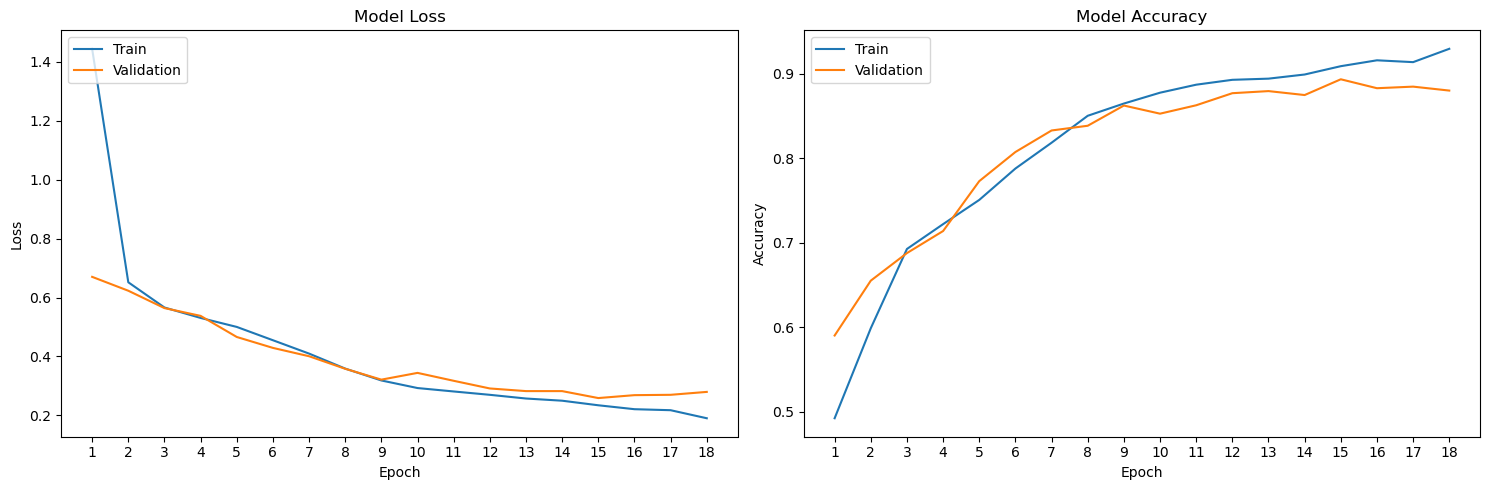

In [7]:
def plot_training_history(history):
    plt.figure(figsize=(15, 5))

    # Number of epochs
    epochs = len(history.history['loss'])

    # Tick marks and labels
    ticks = list(range(epochs))
    labels = [str(i+1) for i in range(epochs)]

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.xticks(ticks, labels)  # Set custom ticks and labels
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['custom_accuracy'])
    plt.plot(history.history['val_custom_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.xticks(ticks, labels)  # Set custom ticks and labels
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

plot_training_history(history)

## Evaluate the model

1/1 [==============================] - 3s 3s/step
   Metric    Value
     Loss 0.277317
 Accuracy 0.891561
 F1 Score 0.864266
Precision 0.830892
   Recall 0.900433


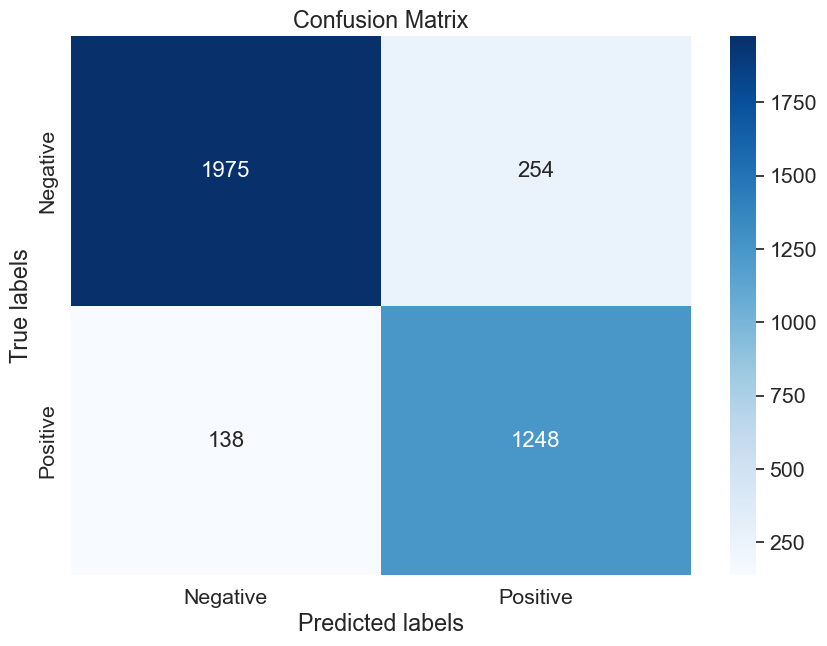

In [14]:
# Define custom objects
custom_objects = {
    'custom_binary_crossentropy': custom_binary_crossentropy,
    'custom_accuracy': custom_accuracy
}

# Load the best model
model_dir = os.path.join('..', 'models', 'CRNN')
best_model_filepath = os.path.join(model_dir, 'best_model_V3.h5')
best_model = load_model(best_model_filepath, custom_objects=custom_objects)

# Evaluate the model on the test dataset
test_loss, test_accuracy = best_model.evaluate(test_dataset, verbose=0)

predictions = best_model.predict(test_dataset)
predicted_labels = np.round(predictions).astype(int) 

true_labels = []
for _, labels in test_dataset:
    true_labels.extend(labels.numpy()) 

true_labels = np.array(true_labels).astype(int) 

# Flatten the arrays
true_labels_flat = true_labels.flatten()
predicted_labels_flat = predicted_labels.flatten()

# Exclude indices with -1 in true labels
valid_indices = true_labels_flat != -1

# Filter both true and predicted labels to include only valid indices
true_labels_filtered = true_labels_flat[valid_indices]
predicted_labels_filtered = predicted_labels_flat[valid_indices]

# Calculate F1 score
f1 = f1_score(true_labels_filtered, predicted_labels_filtered, average='binary')

# Calculate Precision and Recall
precision = precision_score(true_labels_filtered, predicted_labels_filtered, average='binary')
recall = recall_score(true_labels_filtered, predicted_labels_filtered, average='binary')

# Create a DataFrame
results_df = pd.DataFrame({
    "Metric": ["Loss", "Accuracy", "F1 Score", "Precision", "Recall"],
    "Value": [test_loss, test_accuracy, f1, precision, recall]
})
print(results_df.to_string(index=False))

cm = confusion_matrix(true_labels_filtered, predicted_labels_filtered)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.set(font_scale=1.4)  # for label size
sns.heatmap(cm, annot=True, annot_kws={"size": 16}, fmt='g', cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

## Visualizing model predictions 

In [5]:
def custom_binary_crossentropy(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    bce = tf.keras.backend.binary_crossentropy(y_true, y_pred)
    mask = tf.cast(tf.not_equal(y_true, -1), tf.float32)
    loss = bce * mask
    return tf.reduce_sum(loss) / tf.reduce_sum(mask)

def custom_accuracy(y_true, y_pred):
    mask = tf.cast(tf.not_equal(y_true, -1), tf.float32)
    correct_predictions = tf.equal(tf.cast(tf.round(y_pred), tf.float32), y_true)
    masked_correct_predictions = tf.cast(correct_predictions, tf.float32) * mask
    accuracy = tf.reduce_sum(masked_correct_predictions) / tf.reduce_sum(mask)
    return accuracy

# Define custom objects
custom_objects = {
    'custom_binary_crossentropy': custom_binary_crossentropy,
    'custom_accuracy': custom_accuracy
}

model_dir = os.path.join('..', 'models', 'CRNN')
best_model_filepath = os.path.join(model_dir, 'best_model_V3.h5')
model = load_model(best_model_filepath, custom_objects=custom_objects)

1/1 [==============================] - 2s 2s/step


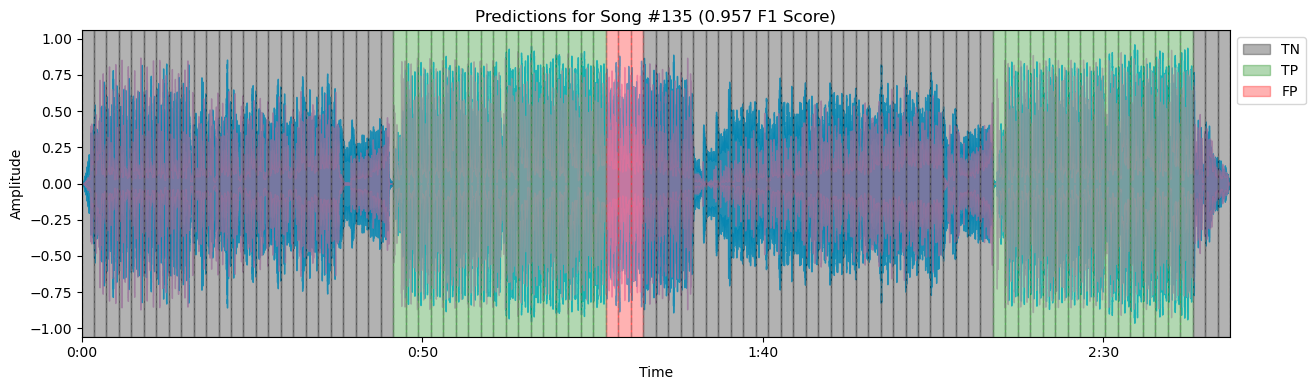

In [6]:
def find_anchor_frame(beats, tempo, sr=12000, hop_length=128):
    """Determine the first beat frame that best matches the expected beat interval given a tempo and sample rate."""
    expected_interval = int(librosa.time_to_frames(60.0 / tempo, sr=sr, hop_length=hop_length))
    best_match_start = max((1 - abs(np.mean(beats[i:i+3]) - expected_interval) / expected_interval, beats[i]) for i in range(len(beats) - 2))[1]
    return best_match_start if best_match_start > 0.95 else beats[0]

def create_meter_grid(beats, tempo, sr, hop_length, frame_duration, time_signature=4):
    """Generate beat grid and meter grid within the duration of a song. Returns beat grid and meter grid in time units or frames."""
    first_beat_time = librosa.frames_to_time(beats[0], sr=sr, hop_length=hop_length)
    time_duration = librosa.frames_to_time(frame_duration, sr=sr, hop_length=hop_length)
    seconds_per_beat = 60.0 / tempo
    num_beats_forward = int((time_duration - first_beat_time) / seconds_per_beat)
    num_beats_backward = int(first_beat_time / seconds_per_beat) + 1
    beat_times_forward = first_beat_time + np.arange(num_beats_forward) * seconds_per_beat
    beat_times_backward = first_beat_time - np.arange(1, num_beats_backward) * seconds_per_beat
    beat_grid = np.concatenate((np.array([0.0]), beat_times_backward[::-1], beat_times_forward))
    meter_indices = np.arange(0, len(beat_grid), time_signature)
    meter_grid = beat_grid[meter_indices]
    if meter_grid[0] != 0.0:
        meter_grid = np.insert(meter_grid, 0, 0.0)
    meter_grid = librosa.time_to_frames(meter_grid, sr=sr, hop_length=hop_length)
    if meter_grid[-1] != frame_duration:
        meter_grid = np.append(meter_grid, frame_duration)
    return meter_grid

def apply_meter_grid(ax, meter_grid_times):
    """For creating grid lines on visualizations"""
    for time in meter_grid_times:
        ax.axvline(x=time, color='grey', linestyle='--', linewidth=1, alpha=0.6)
        
def highlight_predictions(ax, unpadded_predictions, true_labels, meter_grid_times, sr):
    """Overlay the predicted sections based on the meter grid, predictions array, and true labels."""
    # Define colors for each type of prediction
    colors = {'TP': 'green', 'TN': (0, 0, 0, 0.3), 'FP': 'red', 'FN': 'yellow'}
    # Initialize a dictionary to keep track of whether a legend item has been added
    legend_added = {'TP': False, 'TN': False, 'FP': False, 'FN': False}

    for meter_index in range(len(unpadded_predictions)):
        if meter_index == len(meter_grid_times) - 1:
            # Prevent index out of range
            break
        start_time = meter_grid_times[meter_index]
        end_time = meter_grid_times[meter_index + 1]

        # Determine prediction type (True Positive, True Negative, False Positive, False Negative)
        if unpadded_predictions[meter_index] == 1 and true_labels[meter_index] == 1:
            pred_type = 'TP'
        elif unpadded_predictions[meter_index] == 0 and true_labels[meter_index] == 0:
            pred_type = 'TN'
        elif unpadded_predictions[meter_index] == 1 and true_labels[meter_index] == 0:
            pred_type = 'FP'
        elif unpadded_predictions[meter_index] == 0 and true_labels[meter_index] == 1:
            pred_type = 'FN'
        else:
            continue  # Skip if none of the above

        color = colors[pred_type]
        label = pred_type if not legend_added[pred_type] else None
        legend_added[pred_type] = True

        # Highlight the meter
        ax.axvspan(start_time, end_time, color=color, alpha=0.3, label=label)

    # Update the legend to avoid duplicates
    handles, labels = ax.get_legend_handles_labels()
    unique_labels = dict(zip(labels, handles))
    ax.legend(unique_labels.values(), unique_labels.keys(), loc='best')
        
        
def viz_test_predictions(song_id, X_test, y_test, model, df, sr=12000, hop_length=128, save_dir='../images/test_predictions'):
    """
    Visualizing the model's predictions on the test dataset over their audio waveforms and meter-grids
    
    Parameters:
    - song_id: ID of the song to visualize.
    - X_test: Test dataset features.
    - y_test: Test dataset labels.
    - model: Trained model.
    - sr: Sample rate.
    - hop_length: Hop length used for feature extraction.
    - save_dir: Directory to save the visualization.
    """
    features = np.array(X_test[song_id])
    true_labels = y_test[song_id]
    predictions = model.predict(np.expand_dims(features, axis=0)).squeeze()
    
    # Calculate F1 score for the song
    predictions_binary = predictions.round()
    valid_indices = true_labels != -1
    filtered_true_labels = true_labels[valid_indices]
    filtered_predictions = predictions_binary[valid_indices]
    f1 = f1_score(filtered_true_labels, filtered_predictions, average='binary')
    
    # Load song data
    song_id = int(song_id)
    audio_path = f'../data/audio_files/processed/{song_id}.mp3'
    y, sr = librosa.load(audio_path, sr=sr)
    y_harm, y_perc = librosa.effects.hpss(y)
    onset_env = librosa.onset.onset_strength(y=y_perc, sr=sr, hop_length=hop_length)
    tempo, beats = librosa.beat.beat_track(onset_envelope=onset_env, sr=sr, hop_length=hop_length)
    duration_in_frames = len(onset_env)
    
    data = df[df['SongID'] == song_id]
    bpm = data['sp_tempo'].fillna(tempo).replace(0, tempo).clip(lower=70, upper=140).values[0]
    time_signature = int(data['sp_time_signature'].fillna(4).replace(0, 4).values[0])

    meter_grid = create_meter_grid(beats, tempo, sr, hop_length, duration_in_frames, time_signature)
    meter_grid_times = librosa.frames_to_time(meter_grid, sr=sr, hop_length=hop_length)
    
    # Visualize waveform and predictions
    fig, ax = plt.subplots(figsize=(12.5, 4))
    librosa.display.waveshow(y_harm, sr=sr, alpha=0.8, ax=ax, label='Harmonic', color='deepskyblue')
    librosa.display.waveshow(y_perc, sr=sr, alpha=0.7, ax=ax, label='Percussive', color='plum')
    
    ax.set_xlim(0, librosa.get_duration(y=y, sr=sr, hop_length=hop_length))
    apply_meter_grid(ax, meter_grid_times)
    highlight_predictions(ax, filtered_predictions, filtered_true_labels, meter_grid_times, sr)
    
    ax.set_ylabel('Amplitude')
    plt.title(f'Predictions for Song #{song_id} ({f1:.3f} F1 Score)')
    plt.tight_layout()

    # Update the legend to avoid duplicates and place it outside
    handles, labels = ax.get_legend_handles_labels()
    # Filter out 'Harmonic' and 'Percussive' from the legend
    filtered_handles = [h for h, l in zip(handles, labels) if l not in ['Harmonic', 'Percussive']]
    filtered_labels = [l for l in labels if l not in ['Harmonic', 'Percussive']]
    ax.legend(filtered_handles, filtered_labels, loc='upper left', bbox_to_anchor=(1, 1))

    plt.show()
    #plt.savefig(os.path.join(save_dir, f'{song_id}.png'))
    #plt.close()

    
    
df = pd.read_csv('../data/clean_labeled.csv')
song_ids = list(X_test.keys())
random_song_id = np.random.choice(song_ids)
viz_test_predictions(random_song_id, X_test, y_test, model, df, sr=12000, hop_length=128)
 
#for random_song_id in tqdm(song_ids):
#    viz_test_predictions(random_song_id, X_test, y_test, model, df, sr=12000, hop_length=128, save_dir='../images/test_predictions')
    
#print("Figures are stored in '../images/test_predictions folder'")



In [11]:
def viz_test_predictions(song_id, X_test, y_test, model, df, sr=12000, hop_length=128, save_dir='../images/test_predictions'):
    """
    Visualizing the model's predictions on the test dataset over their audio waveforms and meter-grids
    
    Parameters:
    - song_id: ID of the song to visualize.
    - X_test: Test dataset features.
    - y_test: Test dataset labels.
    - model: Trained model.
    - sr: Sample rate.
    - hop_length: Hop length used for feature extraction.
    - save_dir: Directory to save the visualization.
    """
    features = np.array(X_test[song_id])
    true_labels = y_test[song_id]
    predictions = model.predict(np.expand_dims(features, axis=0)).squeeze()
    
    # Calculate F1 score for the song
    predictions_binary = predictions.round()
    valid_indices = true_labels != -1
    filtered_true_labels = true_labels[valid_indices]
    filtered_predictions = predictions_binary[valid_indices]
    f1 = f1_score(filtered_true_labels, filtered_predictions, average='binary')
    
    # Load song data
    song_id = int(song_id)
    audio_path = f'../data/audio_files/processed/{song_id}.mp3'
    y, sr = librosa.load(audio_path, sr=sr)
    y_harm, y_perc = librosa.effects.hpss(y)
    onset_env = librosa.onset.onset_strength(y=y_perc, sr=sr, hop_length=hop_length)
    tempo, beats = librosa.beat.beat_track(onset_envelope=onset_env, sr=sr, hop_length=hop_length)
    duration_in_frames = len(onset_env)
    
    data = df[df['SongID'] == song_id]
    bpm = data['sp_tempo'].fillna(tempo).replace(0, tempo).clip(lower=70, upper=140).values[0]
    time_signature = int(data['sp_time_signature'].fillna(4).replace(0, 4).values[0])

    meter_grid = create_meter_grid(beats, tempo, sr, hop_length, duration_in_frames, time_signature)
    meter_grid_times = librosa.frames_to_time(meter_grid, sr=sr, hop_length=hop_length)
    
    # Visualize waveform and predictions
    fig, ax = plt.subplots(figsize=(12.5, 4))
    librosa.display.waveshow(y_harm, sr=sr, alpha=0.8, ax=ax, label='Harmonic', color='deepskyblue')
    librosa.display.waveshow(y_perc, sr=sr, alpha=0.7, ax=ax, label='Percussive', color='plum')
    
    ax.set_xlim(0, librosa.get_duration(y=y, sr=sr, hop_length=hop_length))
    apply_meter_grid(ax, meter_grid_times)
    highlight_predictions(ax, filtered_predictions, filtered_true_labels, meter_grid_times, sr)
    
    ax.set_ylabel('Amplitude')
    plt.title(f'Predictions for Song #{song_id} ({f1:.3f} F1 Score)')
    plt.tight_layout()

    # Update the legend to avoid duplicates and place it inside the plot area
    handles, labels = ax.get_legend_handles_labels()
    # Filter out 'Harmonic' and 'Percussive' from the legend
    filtered_handles = [h for h, l in zip(handles, labels) if l not in ['Harmonic', 'Percussive']]
    filtered_labels = [l for l in labels if l not in ['Harmonic', 'Percussive']]
    ax.legend(filtered_handles, filtered_labels, loc='upper left', bbox_to_anchor=(0, 1), ncol=2)

    #plt.show()
    plt.savefig(os.path.join(save_dir, f'{song_id}.png'))
    plt.close()

    
    
df = pd.read_csv('../data/clean_labeled.csv')
song_ids = list(X_test.keys())
 
for random_song_id in tqdm(song_ids):
    viz_test_predictions(random_song_id, X_test, y_test, model, df, sr=12000, hop_length=128, save_dir='../images/test_predictions')
    
print("Figures are stored in '../images/test_predictions folder'")

  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 423ms/step
Figures are stored in '../images/test_predictions folder'
